[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/gan/gan_cnn.ipynb)


In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision.utils import make_grid

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Dataset**

In [3]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True) # loading the downloaded dataset

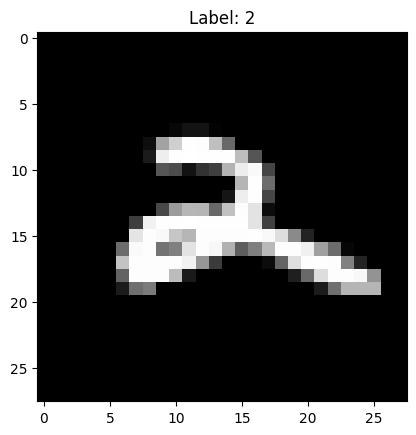

In [5]:
# Display one image from one of the batches
images, labels = next(iter(mnist_loader)) # Extract one batch of images and labels
image = images[0].numpy().squeeze() # loading the one image from that batch
label = labels[0].item() # loading the actual label of the above image

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# **Modelling**

In [12]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.ConvTranspose2d(100, 512, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(512),nn.ReLU(),
                                    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(256),nn.ReLU(),
                                    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.BatchNorm2d(128),nn.ReLU(),
                                    nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.Identity(),nn.Tanh()
                                    )

    def forward(self, z):
        batch_size = z.shape[0]
        out = z.reshape(-1, 100, 1, 1) # reshaping
        out = self.layers(out)
        return out.reshape(batch_size, 1, 28, 28) # reshaping

In [13]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=True), nn.Identity(),nn.LeakyReLU(),
                                    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256),nn.LeakyReLU(),
                                    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512),nn.LeakyReLU(),
                                    nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False), nn.Identity(),nn.Sigmoid(),
                                    )

    def forward(self, x):
        out = self.layers(x)
        return out.reshape(x.size(0))

# **Training**

In [17]:
noise_dim = 100
#IM_CHANNELS = 1 # no of channels in image = 1 cause black and white
#IM_SIZE = (28, 28)
#im_channels = 1
#im_size = 28
#LATENT_DIM = 64 # noisy input dimentions

In [18]:
from torch.optim import Adam

# Instantiate generator model
generator = Generator().to(device)
generator.train()
optimizer_generator = Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999)) #0.5 is momentum

# Instantiate discriminator model
discriminator = Discriminator().to(device)
discriminator.train()
optimizer_discriminator = Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999)) #0.5 is momentum

 12%|█▏        | 109/938 [00:11<01:26,  9.53it/s]


KeyboardInterrupt: 

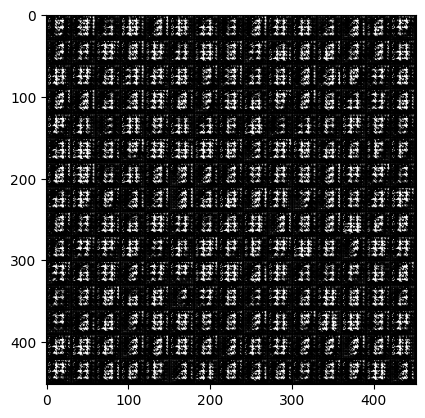

In [19]:
steps = 0
for epoch in range(50): # for each epoch
    generator_losses = []
    discriminator_losses = []
    mean_real_dis_preds = []
    mean_fake_dis_preds = []

    for im, _ in tqdm(mnist_loader): # for each image in each epoch

        real_ims = im.float().to(device)
        batch_size = real_ims.shape[0]

        ''' ######################### First Optimizing the Discriminator ######################### '''

        optimizer_discriminator.zero_grad()

        fake_im_noise = torch.randn((batch_size, noise_dim), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing the noisy data through the generator to get fake image
        disc_real_pred = discriminator(real_ims) # passing real image to the discriminator
        disc_fake_pred = discriminator(fake_ims.detach()) # passing fake image to the discriminator but we are detaching it so that gradients are not computed for generator and generator is not trained while training the discriminator

        disc_loss = -torch.mean(torch.log(disc_real_pred.reshape(-1) + 0.0001) + torch.log(1. - disc_fake_pred.reshape(-1) + 0.0001) )

        disc_loss.backward()
        optimizer_discriminator.step()

        mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())
        mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())


        ''' ######################### Second Optimizing the Generator ######################### '''
        optimizer_generator.zero_grad()

        fake_im_noise = torch.randn((batch_size, noise_dim), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing through generator to create fake image
        disc_fake_pred = discriminator(fake_ims) # passing through discriminator to classify it as fake or real

        gen_fake_loss = -torch.mean(torch.log(disc_fake_pred.reshape(-1) + 0.0001))

        gen_fake_loss.backward()
        optimizer_generator.step()

        generator_losses.append(gen_fake_loss.item())
        discriminator_losses.append(disc_loss.item())

        ''' ######################### Seeing how the generator is improving with training ######################### '''
        if steps % 5 == 0:
            with torch.no_grad():
                generator.eval()

                NUM_SAMPLES = 225
                fake_im_noise = torch.randn((NUM_SAMPLES, noise_dim), device=device) # generating some noisy data
                fake_ims = generator(fake_im_noise) # generating image using generator
                ims = torch.clamp(fake_ims, -1., 1.).detach().cpu() # clamping the generated images
                ims = 0.5*ims + 0.5 #detransforming the images from [-1,1] to [0,1]
                grid = make_grid(ims, nrow=15)
                img = torchvision.transforms.ToPILImage()(grid)
                plt.imshow(img, cmap='gray') # now display the image here using matplot lib

                generator.train()
        steps += 1

    print(f'''Finished epoch:{epoch + 1} | Generator Loss : {np.mean(generator_losses)} | Discriminator Loss : {np.mean(discriminator_losses)} | Discriminator real pred : {np.mean(mean_real_dis_preds)} | Discriminator fake pred : {np.mean(mean_fake_dis_preds)}''')

Key things to note in above training errors :

1. First discriminator loss decreases while generator loss increases => because initially only discriminator is being trained
2. Then the discriminator loss remains constant and the generator loss decreases => because now the discriminator is freezed and the generator is being trained

# **Inference**

In [ ]:
NUM_SAMPLES = 225
fake_im_noise = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device) # generating some noisy data
generated_ims = generator(fake_im_noise) # generating image using generator

In [ ]:
generated_ims = torch.clamp(generated_ims, -1., 1.).detach().cpu() # clamping the generated images
generated_ims = 0.5*generated_ims + 0.5 #detransforming the images from [-1,1] to [0,1]

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_ims, nrow=15)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray') # now display the image here using matplot lib